# Introduction

Some few weeks ago I posted a tweet on “the most common neural net mistakes”, listing a few common gotchas related to training neural nets. The tweet got quite a bit more engagement than I anticipated (including a webinar :)). Clearly, a lot of people have personally encountered the large gap between “here is how a convolutional layer works” and “our convnet achieves state of the art results”.

# The data

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/home/awesomeville/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/awesomeville/.fastai/data/oxford-iiit-pet/images')]

In [3]:
(path/'images').ls()[0]

Path('/home/awesomeville/.fastai/data/oxford-iiit-pet/images/Birman_115.jpg')

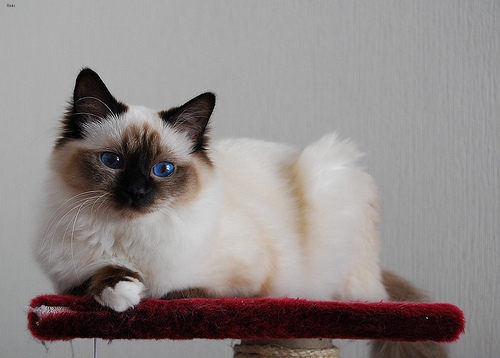

In [4]:
img_path = (path/'images').ls()[0]
PILImage.create(img_path)

In [5]:
img_paths = [path for path in (path/'images').ls() if path.suffix=='.jpg']
print(len(img_paths))

sizes = pd.Series(PILImage.create(img_path).shape for img_path in img_paths)
sizes.value_counts()

7390


(375, 500)    1425
(333, 500)    1072
(500, 375)     511
(500, 333)     509
(225, 300)     266
              ... 
(300, 221)       1
(180, 272)       1
(398, 400)       1
(480, 383)       1
(211, 300)       1
Name: count, Length: 1022, dtype: int64

In [6]:
def get_label(img_path):
    img_name = img_path.name
    x = img_name.split('.')[0]
    return '_'.join(x.split('_')[:-1])

In [7]:
labels = pd.Series(get_label(img_path) for img_path in img_paths)
labels.value_counts()

Birman                        200
leonberger                    200
Bombay                        200
japanese_chin                 200
saint_bernard                 200
Ragdoll                       200
Persian                       200
english_setter                200
havanese                      200
great_pyrenees                200
Bengal                        200
basset_hound                  200
Egyptian_Mau                  200
american_pit_bull_terrier     200
american_bulldog              200
english_cocker_spaniel        200
newfoundland                  200
shiba_inu                     200
samoyed                       200
miniature_pinscher            200
german_shorthaired            200
British_Shorthair             200
pomeranian                    200
yorkshire_terrier             200
chihuahua                     200
Sphynx                        200
beagle                        200
keeshond                      200
boxer                         200
Maine_Coon    

In [8]:
x_tfms = [PILImage.create, Resize(350), ToTensor()]
categories = Categorize(vocab=labels.unique())
y_tfms = [Transform(get_label), categories]
dsets = Datasets(img_paths, [x_tfms, y_tfms])

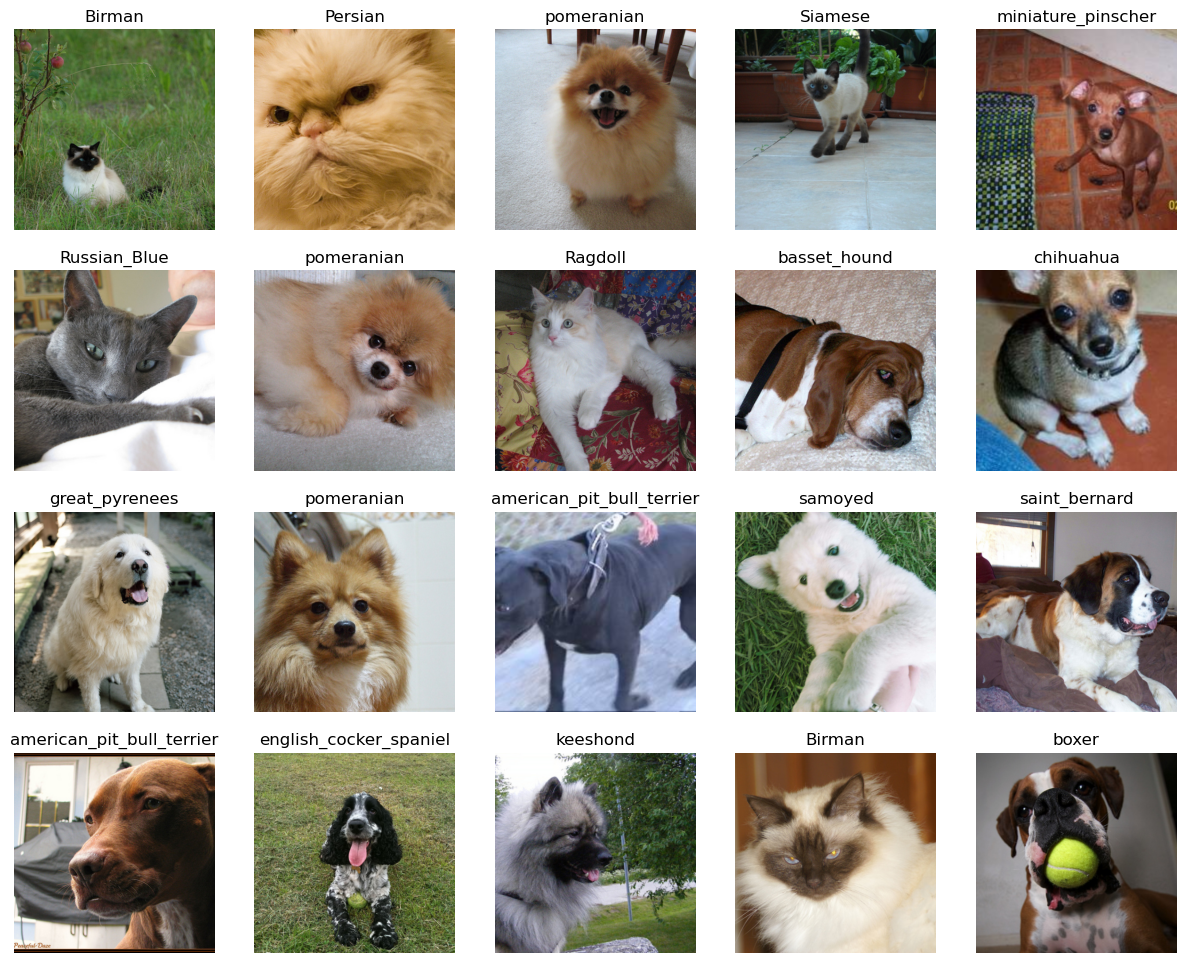

In [9]:
dls = dsets.dataloaders(bs=32)
dls.show_batch(max_n=20, ncols=5)

In [10]:
dsets = dsets = Datasets(img_paths, [x_tfms, y_tfms], splits=RandomSplitter()(img_paths))

def get_dls(bs, resize=128):
    batch_tfms = [IntToFloatTensor(), Resize(resize), Normalize.from_stats(*imagenet_stats)]
    return dsets.dataloaders(bs=bs, after_batch=batch_tfms)

# Baselines

## Dumb baseline

In [11]:
n_classes = len(categories.vocab)
1/n_classes

0.02702702702702703

## Input independent baseline

In [12]:
class ConvBlock(nn.Sequential):
    def __init__(self, ni, nf, stride=2):
        super().__init__(nn.Conv2d(ni, nf, 3, stride=stride), nn.ReLU())

In [13]:
class CNN(nn.Sequential):
    def __init__(self, n_classes, channels=[3,16,32,64,128,256]):
        cnn_layers = [ConvBlock(ni, nf) for ni, nf in zip(channels, channels[1:])]
        pooling = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        super().__init__(
            *cnn_layers, pooling,
            nn.Linear(channels[-1], n_classes)
        )

In [14]:
model = CNN(n_classes)
model

CNN(
  (0): ConvBlock(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (1): ConvBlock(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (2): ConvBlock(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (3): ConvBlock(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (4): ConvBlock(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (5): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (6): Linear(in_features=256, out_features=37, bias=True)
)

In [15]:
def set_zero(self):
    imgs = self.xb[0] # `self.xb` returns a tuple
    input = torch.zeros(imgs.size(), device=imgs.device)
    self.learn.xb = (input,) # `self.xb` is read only

In [16]:
dls = get_dls(bs=128, resize=128)
cbs = Callback(after_batch=set_zero)
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=accuracy, cbs=cbs)

In [18]:
learn.fit(n_epoch=3, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.611742,3.610858,0.025034,01:40
1,3.610770,3.609880,0.036536,01:47
2,3.608528,3.606041,0.034506,01:49


## Vanilla training

In [28]:
def get_learner(bs=128, resize=128, channels=[3,16,32,64,128,256]):
    dls = get_dls(bs, resize)
    model = CNN(n_classes, channels)
    return Learner(dls, model, loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=accuracy)

In [30]:
learn = train(10, 0.02, bs=64)

epoch,train_loss,valid_loss,accuracy,time
0,3.611866,3.611458,0.026387,00:20
1,3.612259,3.611712,0.026387,00:21
2,3.612073,3.611971,0.026387,00:20
3,3.611733,3.612235,0.026387,00:20
4,3.611475,3.612487,0.026387,00:20
5,3.611220,3.612726,0.026387,00:20
6,3.611147,3.612953,0.021651,00:20
7,3.610964,3.613166,0.021651,00:20
8,3.611046,3.613397,0.021651,00:20
9,3.611160,3.613591,0.021651,00:20


In [ ]:
learn = train(15, 0.2, bs=256)

In [ ]:
dls = get_dls(256, augs=[Resize(224)])
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=accuracy)

## Trying to overfit

# Improving training stability

## Weight initialization

## Normalization

## Skip connections

# Training faster